In [37]:
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from utilities.storage import get_dot_product_bm25_selected_files, get_dot_product_bm25_selected_model_generated_files

In [38]:
def calculate_cosine_similarity(a_dot_b, a_dot_a, b_dot_b):
    return a_dot_b / (math.sqrt(a_dot_a) * math.sqrt(b_dot_b))

In [39]:
def calculate_score(gradient_similarities: dict):
    correct_counter = 0
    bm25_correct_counter = 0

    size = len(gradient_similarities.keys())

    for paraphrased_id, similarities in gradient_similarities.items():
        most_similar_original_id = max(similarities, key=similarities.get)
        correct_counter += int(paraphrased_id == most_similar_original_id)

        bm25_most_similar_original_id = list(similarities.keys())[0]
        bm25_correct_counter += int(paraphrased_id == bm25_most_similar_original_id)

    return correct_counter / size, bm25_correct_counter / size

In [40]:
def get_wrong_decisions(gradient_similarities: dict):
    wrong_decisions = []

    for original_id, similarities in gradient_similarities.items():
        most_similar_paraphrased_id = max(similarities, key=similarities.get)
        if original_id != most_similar_paraphrased_id:
            wrong_decisions.append(original_id)

    return wrong_decisions

In [41]:
def get_mean_similarity_of_most_similar_samples(gradient_similarities: dict, mean_function = np.mean):
    highest_similarities = []

    for original_id, similarities in gradient_similarities.items():
        highest_similarities.append(max(similarities.values()))

    return mean_function(highest_similarities)

In [42]:
def calculate_accuracy_per_layer(cosine_similarities_new_structure: dict):
    correct_counter_per_layer = defaultdict(int)

    # amount of paraphrased_samples
    size = len(next(iter(cosine_similarities_new_structure.values())).keys())

    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            most_similar_original_id = max(original_ids, key=original_ids.get)
            correct_counter_per_layer[layer] += int(paraphrased_id == most_similar_original_id)

        # divide by size to get percentage
        correct_counter_per_layer[layer] /= size

    return correct_counter_per_layer

In [43]:
def get_cosine_similarities(dot_product_storage_function):
    dot_products, paraphrased_dot_products, original_dot_products = dot_product_storage_function(model_to_evaluate, sample_size)

    # restructure such that layer is at outermost level in the dictionary for easier access afterward
    cosine_similarities_new_structure = dict()
    cosine_similarities_old_structure = dict()

    cosine_similarities_old_structure_combined = dict()

    for paraphrased_id, values in dot_products.items():
        cosine_similarities_old_structure[paraphrased_id] = dict()
        cosine_similarities_old_structure_combined[paraphrased_id] = dict()

        for original_id, layers in values.items():
            cosine_similarities_old_structure[paraphrased_id][original_id] = dict()
            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = 0

            for layer, value in layers.items():
                if layer not in cosine_similarities_new_structure:
                    cosine_similarities_new_structure[layer] = dict()

                if paraphrased_id not in cosine_similarities_new_structure[layer]:
                    cosine_similarities_new_structure[layer][paraphrased_id] = dict()

                cosine_similarity = calculate_cosine_similarity(value, paraphrased_dot_products[paraphrased_id][layer], original_dot_products[original_id][layer])

                cosine_similarities_old_structure[paraphrased_id][original_id][layer] = cosine_similarity
                cosine_similarities_new_structure[layer][paraphrased_id][original_id] = cosine_similarity

                cosine_similarities_old_structure_combined[paraphrased_id][original_id] += value

            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = calculate_cosine_similarity(
                cosine_similarities_old_structure_combined[paraphrased_id][original_id],
                sum(paraphrased_dot_products[paraphrased_id].values()),
                sum(original_dot_products[original_id].values())
            )

    # check if restructuring has worked by comparing iteratively with gradient_similarities dictionary
    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            for original_id, similarity in original_ids.items():
                assert similarity == cosine_similarities_old_structure[paraphrased_id][original_id][layer]

    return cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined

In [44]:
model_to_evaluate = "amd/AMD-OLMo-1B-SFT"
sample_size = 100

#model_to_evaluate = "openai-community/gpt2"
#sample_size = 2

In [45]:
cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined = get_cosine_similarities(get_dot_product_bm25_selected_files)

# 1. BM25 Selected

In [46]:
model_score, bm25_score = calculate_score(cosine_similarities_old_structure_combined)
wrong_decisions = get_wrong_decisions(cosine_similarities_old_structure_combined)
mean_similarity = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined)
mean_similarity_score_median = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined, np.median)

print(f"Model score: {model_score}")
print(f"BM25 score: {bm25_score}")
print(f"Mean similarity (average): {mean_similarity}")
print(f"Mean similarity (median): {mean_similarity_score_median}")

Model score: 1.0
BM25 score: 0.99
Mean similarity (average): 0.5226305914835123
Mean similarity (median): 0.5039189776453838


# 1.1 Layer Analysis

In [47]:
correct_counter_per_layer = calculate_accuracy_per_layer(cosine_similarities_new_structure)

[]

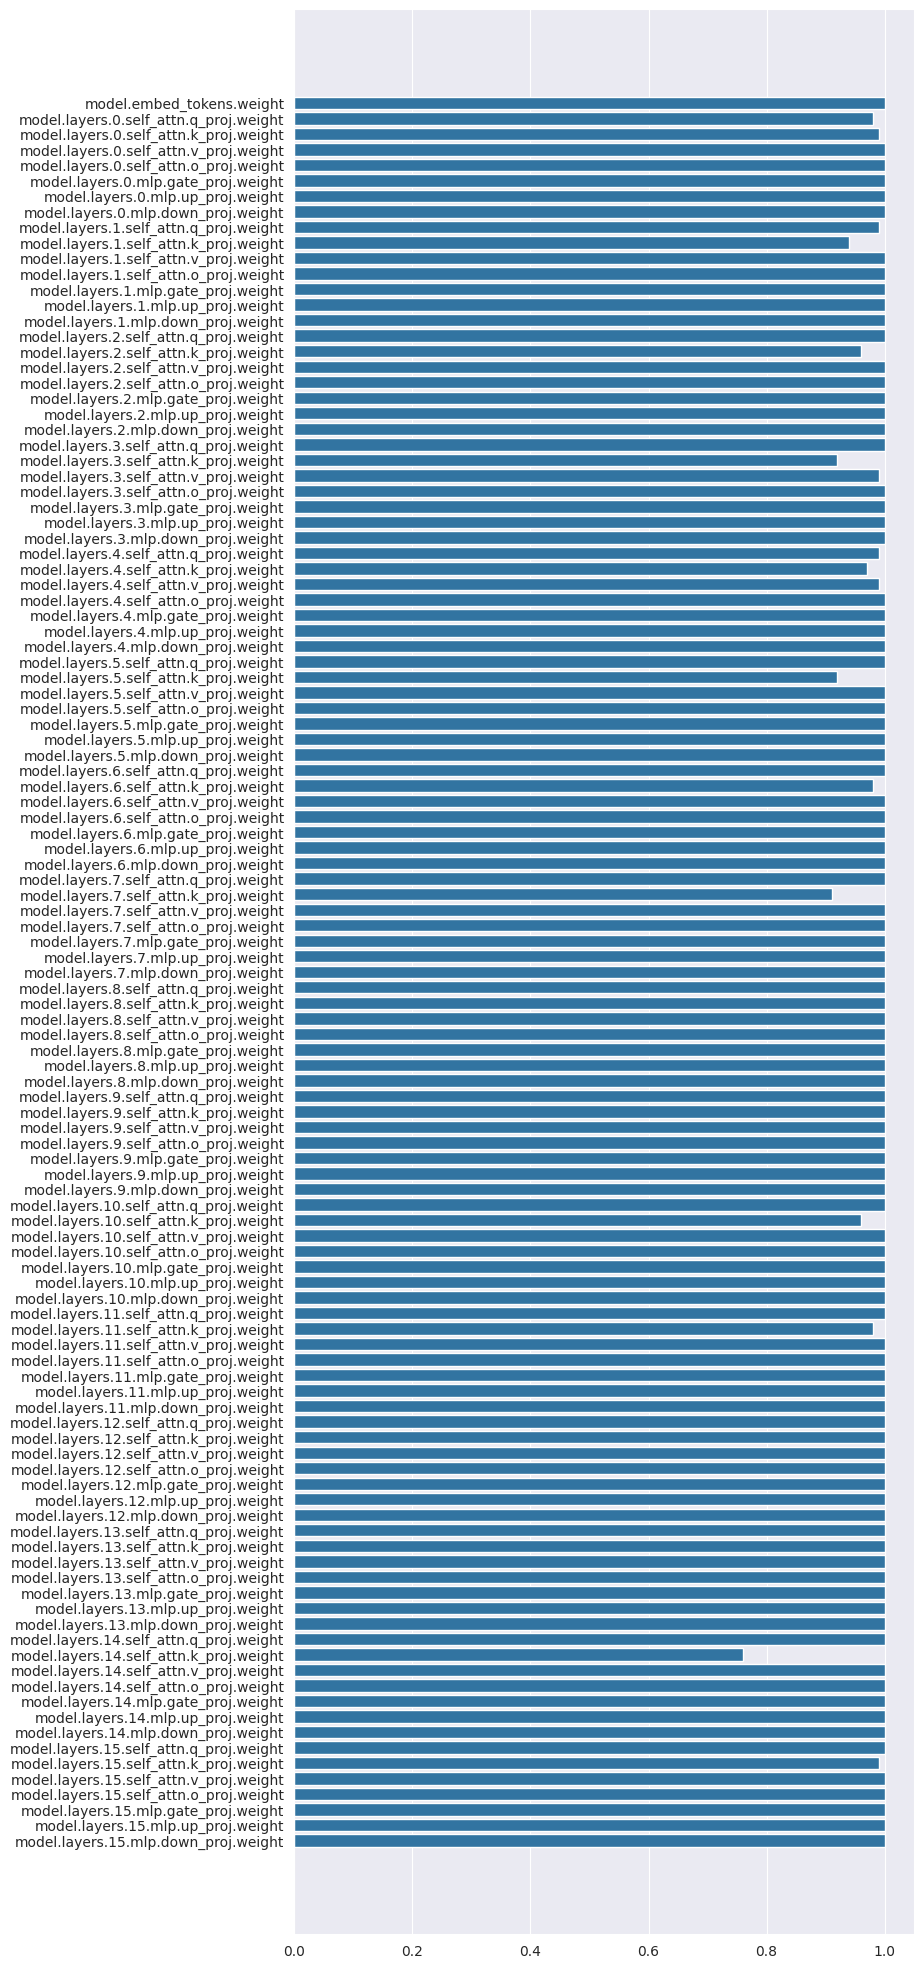

In [48]:
plt.figure(figsize=(8, 25))
sns.barplot(y = list(correct_counter_per_layer.keys()), x = list(correct_counter_per_layer.values()), orient="h")
plt.plot()

# 2. BM25 Selected Model Generated

In [49]:
cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_model_generated, cosine_similarities_old_structure_combined_model_generated = get_cosine_similarities(get_dot_product_bm25_selected_model_generated_files)

In [50]:
model_score_model_generated, bm25_score_model_generated = calculate_score(cosine_similarities_old_structure_combined_model_generated)
wrong_decisions_model_generated = get_wrong_decisions(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_score_median_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated, np.median)

print(f"Model score: {model_score_model_generated}")
print(f"BM25 score: {bm25_score_model_generated}")
print(f"Mean similarity (average): {mean_similarity_model_generated}")
print(f"Mean similarity (median): {mean_similarity_score_median_model_generated}")

Model score: 1.0
BM25 score: 0.99
Mean similarity (average): 0.5226305890554814
Mean similarity (median): 0.5039189498310945


# 2.1 Layer Analysis

In [51]:
correct_counter_per_layer_model_generated = calculate_accuracy_per_layer(cosine_similarities_new_structure_model_generated)

[]

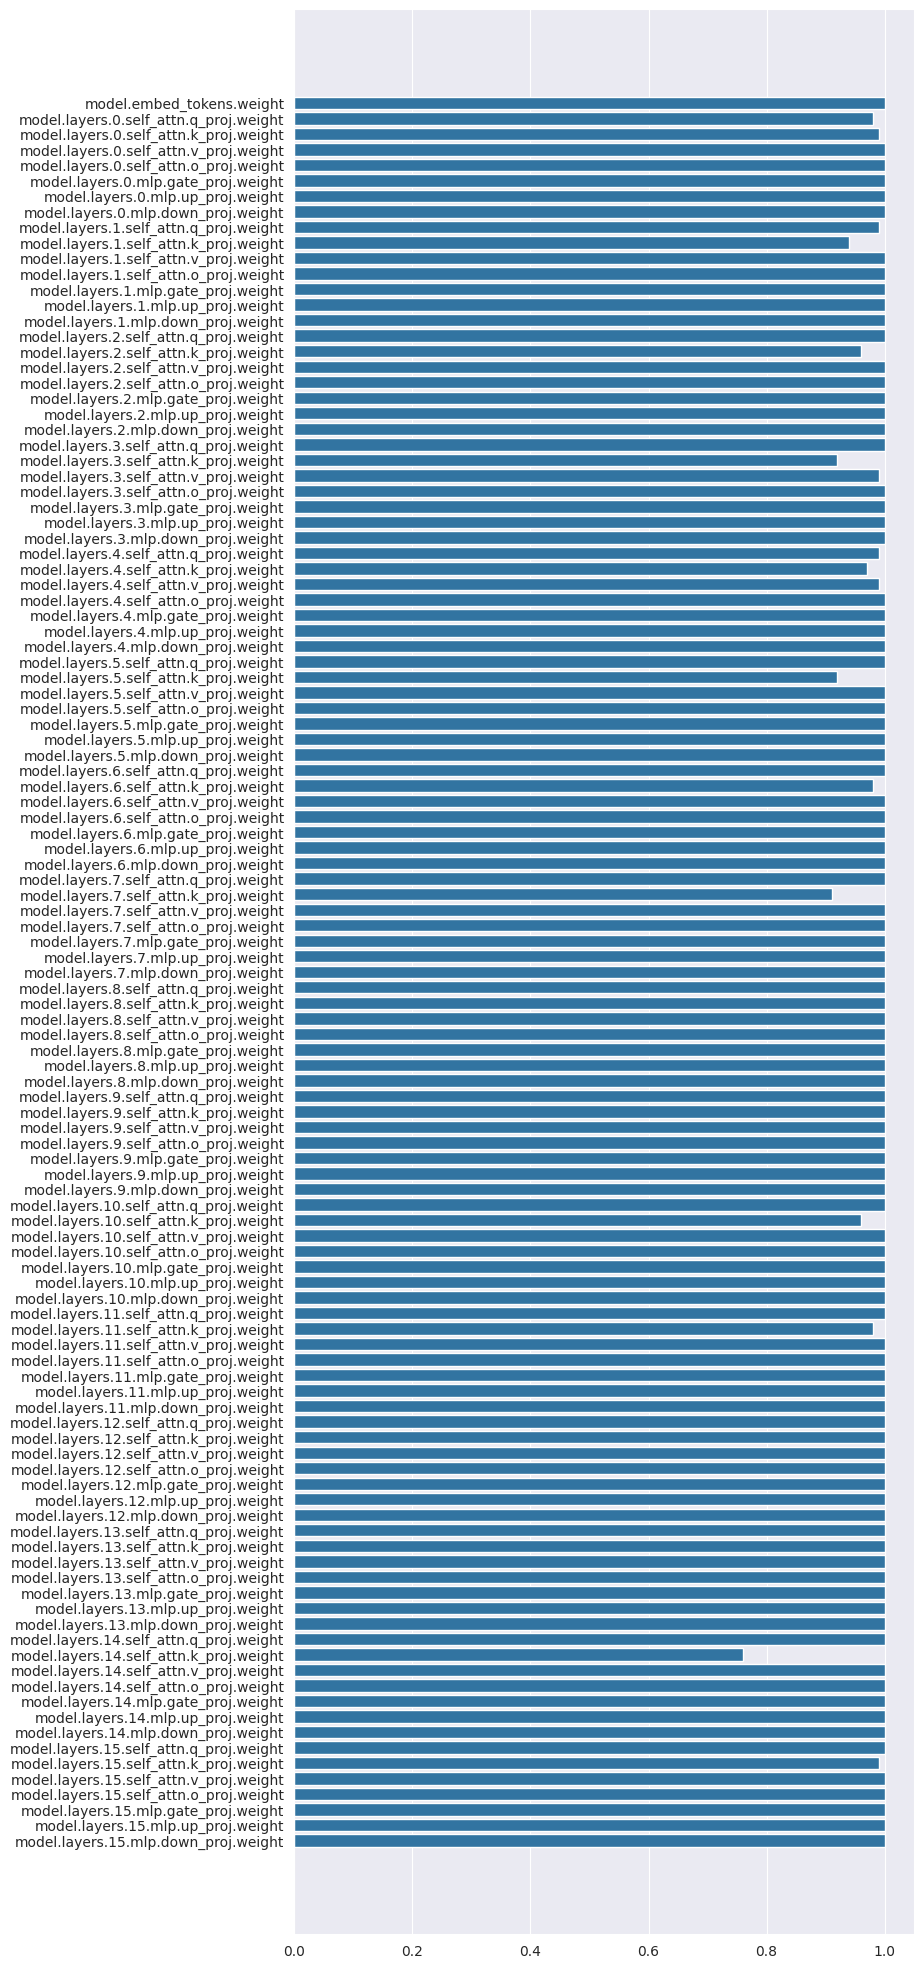

In [52]:
plt.figure(figsize=(8, 25))
sns.barplot(y = list(correct_counter_per_layer_model_generated.keys()), x = list(correct_counter_per_layer_model_generated.values()), orient="h")
plt.plot()

# 3. Comparison

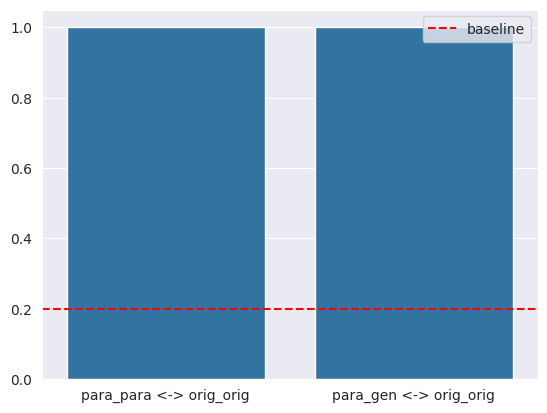

In [53]:
# create bar plot with paraphrased_score, paraphrased_model_generated_score, and horizontal line at 0.2 baseline
sns.barplot(x=["para_para <-> orig_orig", "para_gen <-> orig_orig"], y=[model_score, model_score_model_generated])

plt.axhline(y=0.2, color='r', linestyle='--', label="baseline")
plt.legend()
plt.show()